In [1]:
import os
import pathlib

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

Using TensorFlow backend.


## 1. Set the model configuration parameters

The cell below sets a number of parameters that define the model configuration. The parameters set here are being used both by the `build_model()` function that builds the model as well as further down by the constructor for the `SSDInputEncoder` object that is needed to to match ground truth and anchor boxes during the training.

Here are just some comments on a few of the parameters, read the documentation for more details:

* Set the height, width, and number of color channels to whatever you want the model to accept as image input. If your input images have a different size than you define as the model input here, or if your images have non-uniform size, then you must use the data generator's image transformations (resizing and/or cropping) so that your images end up having the required input size before they are fed to the model. to convert your images to the model input size during training. The SSD300 training tutorial uses the same image pre-processing and data augmentation as the original Caffe implementation, so take a look at that to see one possibility of how to deal with non-uniform-size images.
* The number of classes is the number of positive classes in your dataset, e.g. 20 for Pascal VOC or 80 for MS COCO. Class ID 0 must always be reserved for the background class, i.e. your positive classes must have positive integers as their IDs in your dataset.
* The `mode` argument in the `build_model()` function determines whether the model will be built with or without a `DecodeDetections` layer as its last layer. In 'training' mode, the model outputs the raw prediction tensor, while in 'inference' and 'inference_fast' modes, the raw predictions are being decoded into absolute coordinates and filtered via confidence thresholding, non-maximum suppression, and top-k filtering. The difference between latter two modes is that 'inference' uses the decoding procedure of the original Caffe implementation, while 'inference_fast' uses a faster, but possibly less accurate decoding procedure.
* The reason why the list of scaling factors has 5 elements even though there are only 4 predictor layers in tSSD7 is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. Refer to the documentation for details.
* `build_model()` and `SSDInputEncoder` have two arguments for the anchor box aspect ratios: `aspect_ratios_global` and `aspect_ratios_per_layer`. You can use either of the two, you don't need to set both. If you use `aspect_ratios_global`, then you pass one list of aspect ratios and these aspect ratios will be used for all predictor layers. Every aspect ratio you want to include must be listed once and only once. If you use `aspect_ratios_per_layer`, then you pass a nested list containing lists of aspect ratios for each individual predictor layer. This is what the SSD300 training tutorial does. It's your design choice whether all predictor layers should use the same aspect ratios or whether you think that for your dataset, certain aspect ratios are only necessary for some predictor layers but not for others. Of course more aspect ratios means more predicted boxes, which in turn means increased computational complexity.
* If `two_boxes_for_ar1 == True`, then each predictor layer will predict two boxes with aspect ratio one, one a bit smaller, the other one a bit larger.
* If `clip_boxes == True`, then the anchor boxes will be clipped so that they lie entirely within the image boundaries. It is recommended not to clip the boxes. The anchor boxes form the reference frame for the localization prediction. This reference frame should be the same at every spatial position.
* In the matching process during the training, the anchor box offsets are being divided by the variances. Leaving them at 1.0 for each of the four box coordinates means that they have no effect. Setting them to less than 1.0 spreads the imagined anchor box offset distribution for the respective box coordinate.
* `normalize_coords` converts all coordinates from absolute coordinate to coordinates that are relative to the image height and width. This setting has no effect on the outcome of the training.

In [2]:
batch_size = 16
load_model = True
load_weights = True
model_path = 'ssd7.h5'
initial_epoch = 0
final_epoch = 20
steps_per_epoch = 1000
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [3]:
K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

if load_weights:
    model.load_weights('./ssd7_weights.h5', by_name=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
















Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [4]:
if os.path.exists(model_path) and load_model:
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    K.clear_session()
    model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                                   'compute_loss': ssd_loss.compute_loss})

In [5]:
#%%bash
#FILE_ID='1tfBFavijh4UTG4cGqIKwhcklLXUDuY0D'
#FILE_NAME='dataset.zip'
#cd /content
#curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${FILE_ID}" > /dev/null
#curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=${FILE_ID}" -o ${FILE_NAME}
#unzip dataset.zip
#rm cookie dataset.zip

In [6]:
train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

images_dir = '/home/samuel/school/Project/SSD7_dataset/udacity_driving_datasets/'
train_labels_filename = '/home/samuel/school/Project/SSD7_dataset/udacity_driving_datasets/labels_train.csv'
val_labels_filename   = '/home/samuel/school/Project/SSD7_dataset/udacity_driving_datasets/labels_val.csv'

train_dataset.parse_csv(images_dir=images_dir, 
                        labels_filename=train_labels_filename, 
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], 
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir, 
                      labels_filename=val_labels_filename, 
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], 
                      include_classes='all')

train_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_train.h5', 
                                  resize=False, 
                                  variable_image_size=True,  
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_val.h5', 
                                resize=False, 
                                variable_image_size=True, 
                                verbose=True)

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Creating HDF5 dataset: 100%|██████████| 4241/4241 [00:14<00:00, 284.07it/s]
Number of images in the training dataset:	 18000
Number of images in the validation dataset:	  4241


In [7]:
data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images', 'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images', 'encoded_labels'},
                                     keep_images_without_gt=False)

In [8]:
model_checkpoint = ModelCheckpoint(filepath='ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

/opt/conda/envs/school/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [9]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size / batch_size),
                              initial_epoch=initial_epoch)



Epoch 1/20
1000/1000 [==============================] - 435s 435ms/step - loss: 2.1391 - val_loss: 2.3465

Epoch 00001: val_loss improved from inf to 2.34653, saving model to ssd7_epoch-01_loss-2.1391_val_loss-2.3465.h5
Epoch 2/20
1000/1000 [==============================] - 422s 422ms/step - loss: 2.1361 - val_loss: 2.3375

Epoch 00002: val_loss improved from 2.34653 to 2.33751, saving model to ssd7_epoch-02_loss-2.1361_val_loss-2.3375.h5
Epoch 3/20
1000/1000 [==============================] - 427s 427ms/step - loss: 2.1339 - val_loss: 2.3784

Epoch 00003: val_loss did not improve from 2.33751
Epoch 4/20
1000/1000 [==============================] - 425s 425ms/step - loss: 2.1278 - val_loss: 2.3469

Epoch 00004: val_loss did not improve from 2.33751
Epoch 5/20
1000/1000 [==============================] - 424s 424ms/step - loss: 2.1025 - val_loss: 2.5039

Epoch 00005: val_loss did not improve from 2.33751
Epoch 6/20
1000/1000 [==============================] - 422s 422ms/step - loss: 

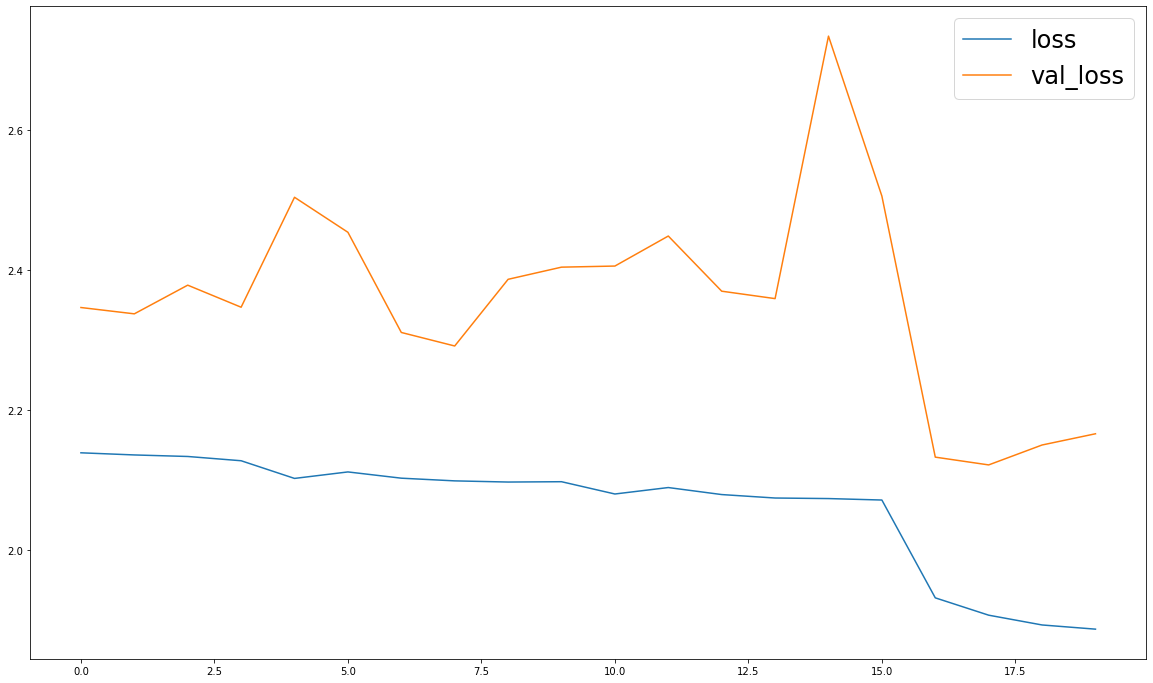

In [10]:
plt.figure(figsize=(20, 12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24})

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [13]:
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

In [14]:
batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0 # Which batch item to look at.
print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: /home/samuel/school/Project/SSD7_dataset/udacity_driving_datasets/1478899843086190887.jpg

Ground truth boxes:

[[  1   6 157  39 178]
 [  1   7 158  39 177]
 [  1  55 155  75 174]
 [  1 136 128 310 266]
 [  1 426 142 478 165]
 [  3 451 120 479 203]
 [  5   0 128   9 145]
 [  5 179 111 188 128]
 [  5 255 117 261 132]]


In [15]:
y_pred = model.predict(batch_images)

In [16]:
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.   130.68 100.22 312.   300.61]
 [  1.     0.95  52.55 155.85  77.55 174.27]
 [  1.     0.67   5.08 155.88  38.9  175.82]]


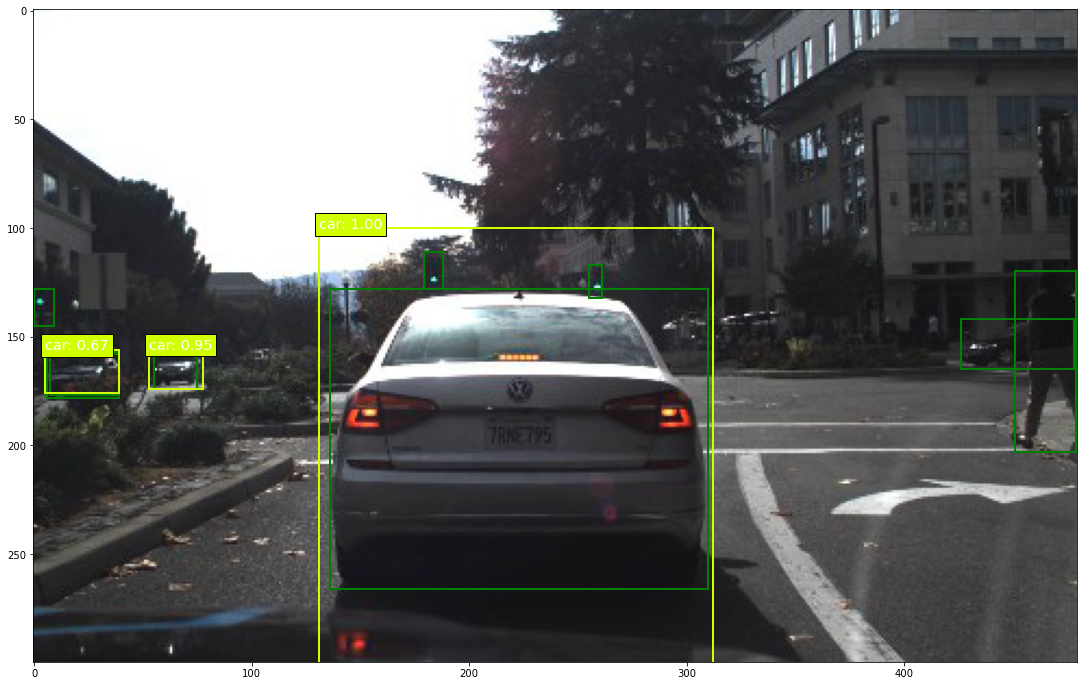

In [17]:
plt.figure(figsize=(20, 12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes + 1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})